Notebook to determine the noise level in AZKABAN during zooplankton experiment January 2022 in Ny-Ålesund

In [23]:
import csv
import os
import glob
from datetime import timedelta
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import matplotlib.dates as mdates
import sys
sys.path.append('../AZKABANML')

import warnings
%matplotlib inline

In [2]:
sys.path.append('C:/Users/mbd/phd/AZKABANML/AZKABANML.py')

In [3]:
import AZKABANML

In [4]:
AZKABANML

<module 'AZKABANML' from 'C:\\Users\\mbd\\phd\\NoiseLevel\\../AZKABANML\\AZKABANML.py'>

In [5]:
#sns.set_theme(style="whitegrid")
palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1


one_col = 85 *0.0393701
two_col = 170*0.0393701

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Figs/'

## Analysis
In Echoview, Single Echo Detection + 2.0m mask on TS data, only noise left.

Export TS (nominal frequency) of noise.

In [190]:
def tsf_targets_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df, avg_flag):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        if avg_flag:
            df['Ping_microseconds_start'] = df.Ping_millisecond_start * 1000
            df['Ping_microseconds_start'] = [timedelta(microseconds = i) for i in df['Ping_microseconds_start']]
            df['Datetime'] = df['Ping_date_start_Ping_time_start'] + df['Ping_microseconds_start']
            df.drop(columns=['Ping_date_start_Ping_time_start',
                             'Ping_millisecond_start',
                             'Ping_microseconds_start'], 
                    inplace=True)
        
        else:
            df['Ping_microseconds'] = df.Ping_milliseconds * 1000
            df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
            df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
            df.drop(columns=['Ping_date_Ping_time',
                             'Ping_milliseconds',
                             'Ping_microseconds'],
                    inplace=True)
        
        return df
    
    if "trackavg.csv" in file_path:
        parse_cols = ['Ping_date_start', 'Ping_time_start']
        ind_col = None
        avg_flag = True
        transpose = True
    elif "target" in file_path:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = None
        avg_flag = False
        transpose = False
    else:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = None
        avg_flag = False
        transpose = True
        
    if transpose:
        transposed_path = file_path[:-4] + '_transposed.csv'
        if os.path.isfile(transposed_path) == True:
            df = pd.read_csv(transposed_path,
                             index_col=ind_col,
                             skiprows=1,
                             skipfooter=2,
                             engine='python',
                             parse_dates=[parse_cols])
        else:
            df = pd.read_csv(file_path, low_memory=False).T
            file_path = transposed_path
            df.to_csv(path_or_buf=file_path)
            print('A transposed TS(f) file was created at: \n' + str(file_path))    
            df = pd.read_csv(file_path,
                             index_col=ind_col,
                             skiprows=1,
                             skipfooter=2,
                             engine='python',
                             parse_dates=[parse_cols])
    else:
        df = pd.read_csv(file_path,
                 index_col=ind_col,
                 skiprows=0,
                 skipfooter=2,
                 engine='python',
                 parse_dates=[parse_cols])
    
    df = get_datetime(df, avg_flag)
    
    return df

In [191]:
#Read file
flist = glob.glob('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise/noiseTSF_??.csv')

nfiles = len(flist)        
#time_cols = [0,4,5]
#noise_TS = pd.read_csv(fname,header=None, skiprows=1,index_col = 0)#, usecols=np.append(time_cols,TS_cols))


In [251]:
TS_data = np.empty((nfiles,147))
for i in range(0,nfiles):
    TS_data_read = tsf_targets_import(flist[i])
    TS_data_thres = np.where(TS_data_read.iloc[:,:-1]<-999,np.nan,TS_data_read.iloc[:,:-1])
    TS_data_new = np.nanmedian(TS_data_thres,axis=0)
    
    TS_data[i,:] = TS_data_new

In [254]:
TS_data[:,36]

array([-120.5096  , -118.215024, -121.984905, -129.033213, -123.438793,
       -111.799009, -100.991963, -112.578816, -117.265795, -116.969085,
       -117.535176, -116.443108, -115.665029, -112.193323, -104.144775,
       -109.407018, -108.795453, -105.761591, -107.427146, -101.894189])

### Make datetime array

### Read TS data

### Plot data

### Project to range axis only (median across time) and smooth
use a 0.1 m depth filter

In [279]:
noise_TS = TS_data[:,6:-1]

In [256]:
smooth_TS = TS_data[:,36]
depth_smooth = TS_data[:,2]

### plot noise profile with used range limits indicated

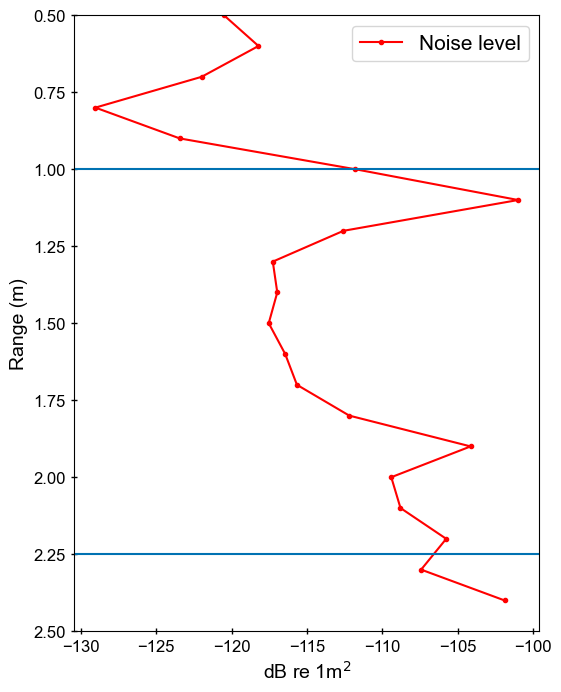

In [257]:
plt.figure(figsize=(6,8))
plt.plot( TS_data[:,36],TS_data[:,2], 'r.-', label='Noise level')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()

### Export to file 

In [258]:
noise_df = pd.DataFrame({'range':depth_smooth,'TS':smooth_TS})
noise_df = noise_df.reset_index()

In [260]:
noise_df.to_feather('Noise_AZKABAN_200kHz_260723.feather')

# Read SED
Compare TS from SEDs with regular parameters to the noise level

In [261]:
def tsf_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        df['Ping_microseconds'] = df.Ping_milliseconds * 1000
        df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
        df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
        df.drop(columns=['Ping_date_Ping_time',
                         'Ping_milliseconds',
                         'Ping_microseconds'],
               inplace=True)
        
        return df
    
    transposed_path = file_path[:-4] + '_transposed.csv'
    if os.path.isfile(transposed_path) == True:
        df = pd.read_csv(transposed_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    else:
        df = pd.read_csv(file_path, low_memory=False).T
        file_path = transposed_path
        df.to_csv(path_or_buf=file_path)
        print('A transposed TS(f) file was created at: \n' + str(file_path))    
        df = pd.read_csv(file_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    
    df = get_datetime(df)
    
    return df


In [262]:
track_df = tsf_import('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/SED_ZoopMix_FTwindow33pl_tracks.csv')

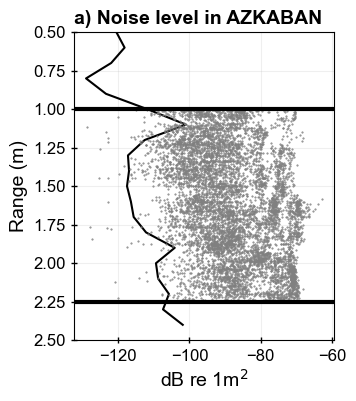

In [263]:
fig, ax = plt.subplots(1,1,figsize=(one_col,4))
ax.grid(True,alpha=0.2)
ax.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
ax.plot(track_df['200.000'],track_df['Range'], '.', color='grey',markersize=1)
ax.axhline(y=1, c='k', linewidth=3)
ax.axhline(y=2.25, c='k', linewidth=3)
plt.ylim([0.5,2.5])
ax.set_xlabel('dB re 1m$^2$')
ax.set_ylabel('Range (m)')
#plt.legend(fontsize=15)
ax.set_title('a) Noise level in AZKABAN', fontsize=BIGGER_SIZE, fontweight='bold', loc='left')
ax.invert_yaxis()


ax.set_rasterized(True)

fig.savefig(savefigs_path +'Figure 7_noise.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigs_path +'Figure 7_noise.tiff', format='tiff', dpi = 300, facecolor='w', bbox_inches='tight')

# Find # less than 10 dB SNR with AVERAGE noise

In [293]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [295]:
SNR = np.zeros([len(track_df)])

for i in range(len(track_df)):
    range_ind = find_nearest(depth_smooth,track_df['Range'][i])
    SNR[i] = track_df['200.000'][i]-smooth_TS[range_ind]

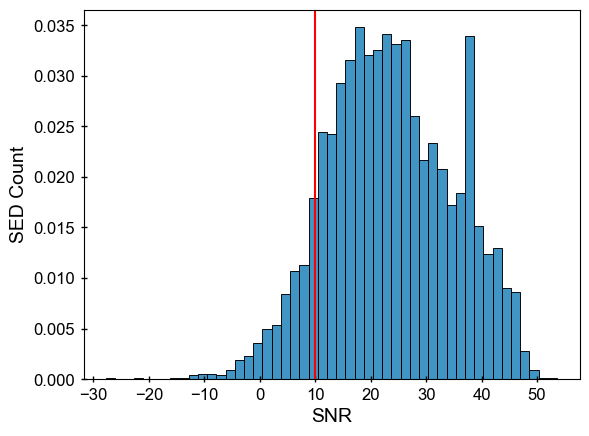

In [296]:
sns.histplot(SNR, stat='density');
plt.ylabel('SED Count')
plt.xlabel('SNR')
plt.axvline(x=10, c='r')

In [297]:
# Calculate values with SNR <10 dB
SNR_less10 = np.count_nonzero(np.where(SNR<10))
print(f'%0.2f percent of SED have a signal (at nominal frequency) of < 10dB above the average noise level at the target detpth' % (SNR_less10/len(track_df)*100))

10.62 percent of SED have a signal (at nominal frequency) of < 10dB above the average noise level at the target detpth


In [298]:
SED_TS = track_df.iloc[:,4:-1]

In [269]:
noise_TS

array([[ 184.5     ,  184.5     ,  184.5     , ...,  184.5     ,
         184.5     ,  184.5     ],
       [ 184.5     ,  184.5     ,  184.5     , ...,  184.5     ,
         184.5     ,  184.5     ],
       [   1.6     ,    1.7     ,    1.8     , ...,    2.1     ,
           2.2     ,    2.3     ],
       ...,
       [-107.787008, -115.659127, -115.574121, ..., -115.074675,
        -105.91936 , -108.641969],
       [-107.988343, -114.57908 , -117.203354, ..., -115.159212,
        -105.938537, -108.945438],
       [-107.230275, -114.33495 , -116.450366, ..., -112.954014,
        -105.609096, -109.172295]])

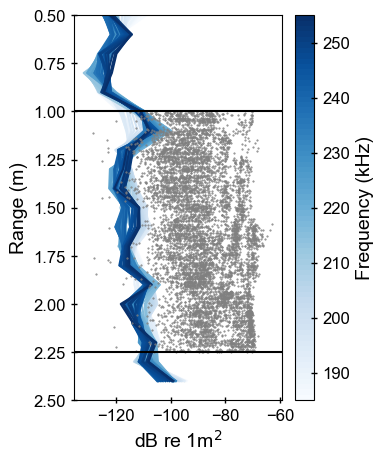

In [281]:
freq = np.linspace(185,255,71)
cmap = plt.get_cmap('Blues', 71)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=185, vmax=255))

fig = plt.figure(figsize=(one_col,5))
for i in range(len(freq)):
    plt.plot(noise_TS[:,i], depth_smooth, color=cmap(i))
    
plt.plot(track_df['200.000'],track_df['Range'], '.', color='grey',markersize=1)
c= plt.colorbar(sm, label='Frequency (kHz)')
plt.axhline(y=1, c='k')
plt.axhline(y=2.25, c='k')
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.gca().invert_yaxis()

fig.savefig(savefigs_path +'Figure4_noise.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigs_path +'Figure4_noise.tiff', format='tiff', dpi = 300, facecolor='w', bbox_inches='tight')